In [2]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Preprocessing & utilities
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Feature selection
from sklearn.feature_selection import RFE, SelectKBest, f_classif, mutual_info_classif

# Metrics
from sklearn.metrics import (
    mean_squared_error, confusion_matrix, precision_score, recall_score,
    auc, roc_curve, accuracy_score, classification_report
)

# Classifiers
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, IsolationForest
)
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# Sampling for imbalance handling
from imblearn.over_sampling import SMOTE



In [3]:
df = pd.read_csv("/content/drive/MyDrive/liver disease dataset/nafld1.csv")
df.head()

,Unnamed: 0,id,age,male,weight,height,bmi,case.id,futime,status
0,3631,1,57,0,60.0,163.0,22.690939,10630.0,6261,0
1,8458,2,67,0,70.4,168.0,24.884028,14817.0,624,0
2,6298,3,53,1,105.8,186.0,30.453537,3.0,1783,0
3,15398,4,56,1,109.3,170.0,37.830100,6628.0,3143,0
4,13261,5,68,1,NaN,NaN,NaN,1871.0,1836,1


# Data cleaning

In [4]:
df.isnull().sum()

,0
Unnamed: 0,0
id,0
age,0
male,0
weight,4786
height,3168
bmi,4961
case.id,31
futime,0
status,0


In [5]:
for col in df.columns:
    if df[col].dtype == "object":  # Categorical columns
        df[col].fillna(df[col].mode()[0], inplace=True)  # Fill with mode
    else:  # Numerical columns
        df[col].fillna(df[col].median(), inplace=True)  # Fill with median

In [6]:
df.isnull().sum()

,0
Unnamed: 0,0
id,0
age,0
male,0
weight,0
height,0
bmi,0
case.id,0
futime,0
status,0


In [7]:
# Check number of duplicates
print("Number of duplicate rows:", df.duplicated().sum())

# Remove them
df.drop_duplicates(inplace=True)
print("Shape after removing duplicates:", df.shape)


Number of duplicate rows: 0
Shape after removing duplicates: (17549, 10)


# Outlier finding

In [9]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

In [10]:

# Function to cap outliers using .clip()
def cap_outliers(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Capping using clip
        df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
    return df

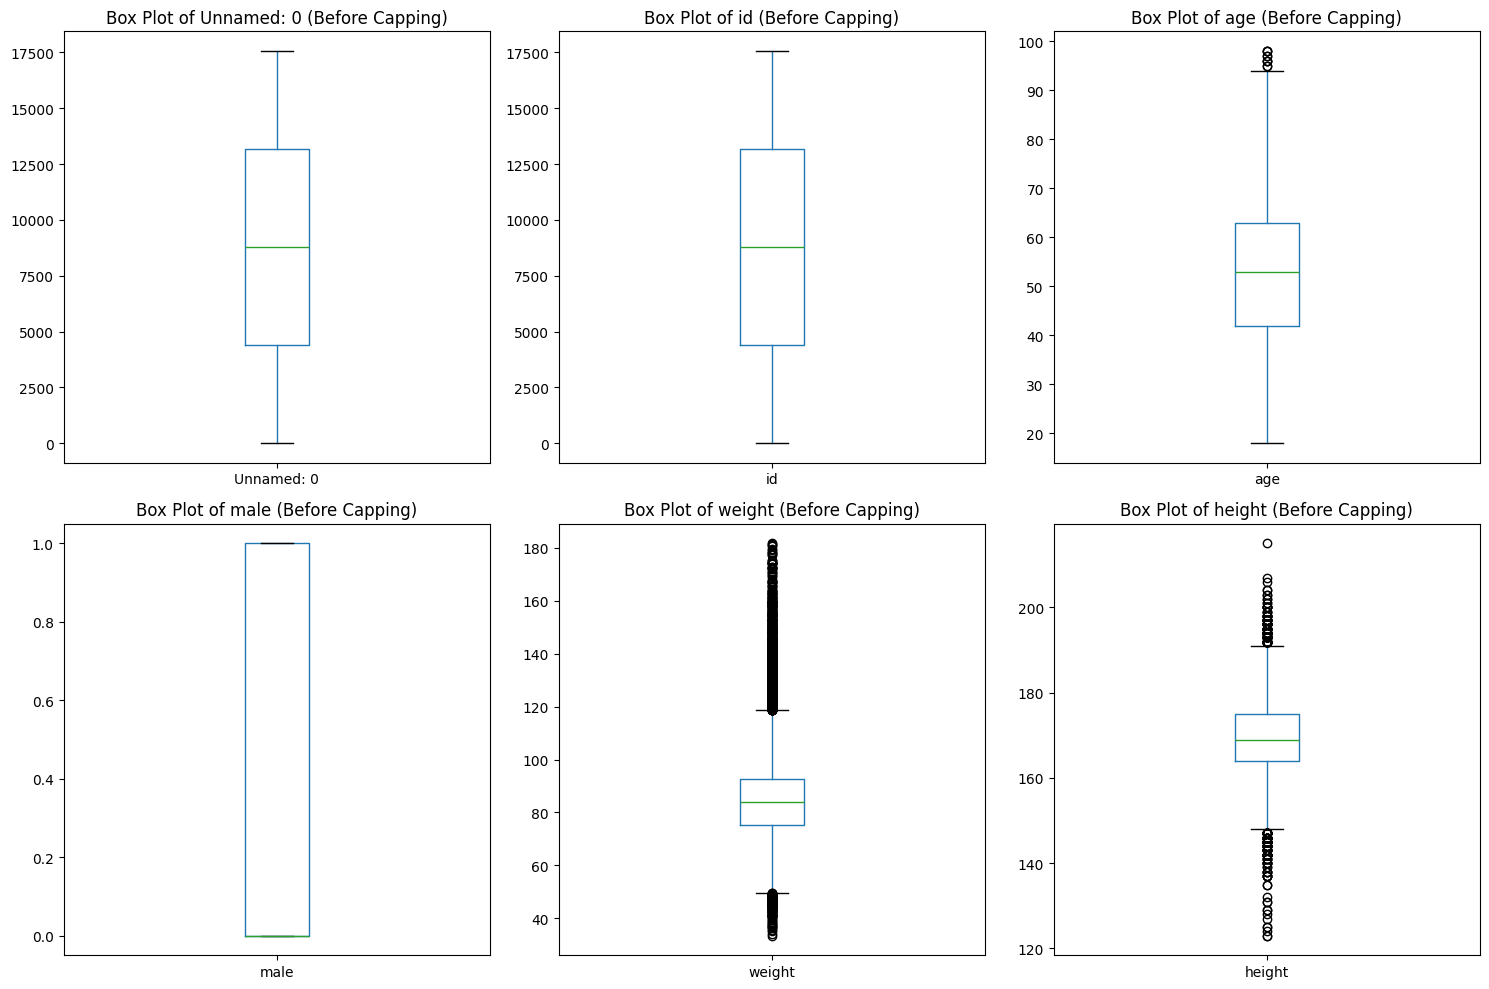

In [11]:
# Plot boxplots BEFORE capping
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features[:6], 1):  # Show first 6 for clarity
    plt.subplot(2, 3, i)
    df.boxplot(column=[feature])
    plt.title(f'Box Plot of {feature} (Before Capping)')
    plt.grid(False)
plt.tight_layout()
plt.show()

In [12]:
df_capped = cap_outliers(df.copy(), numerical_features)

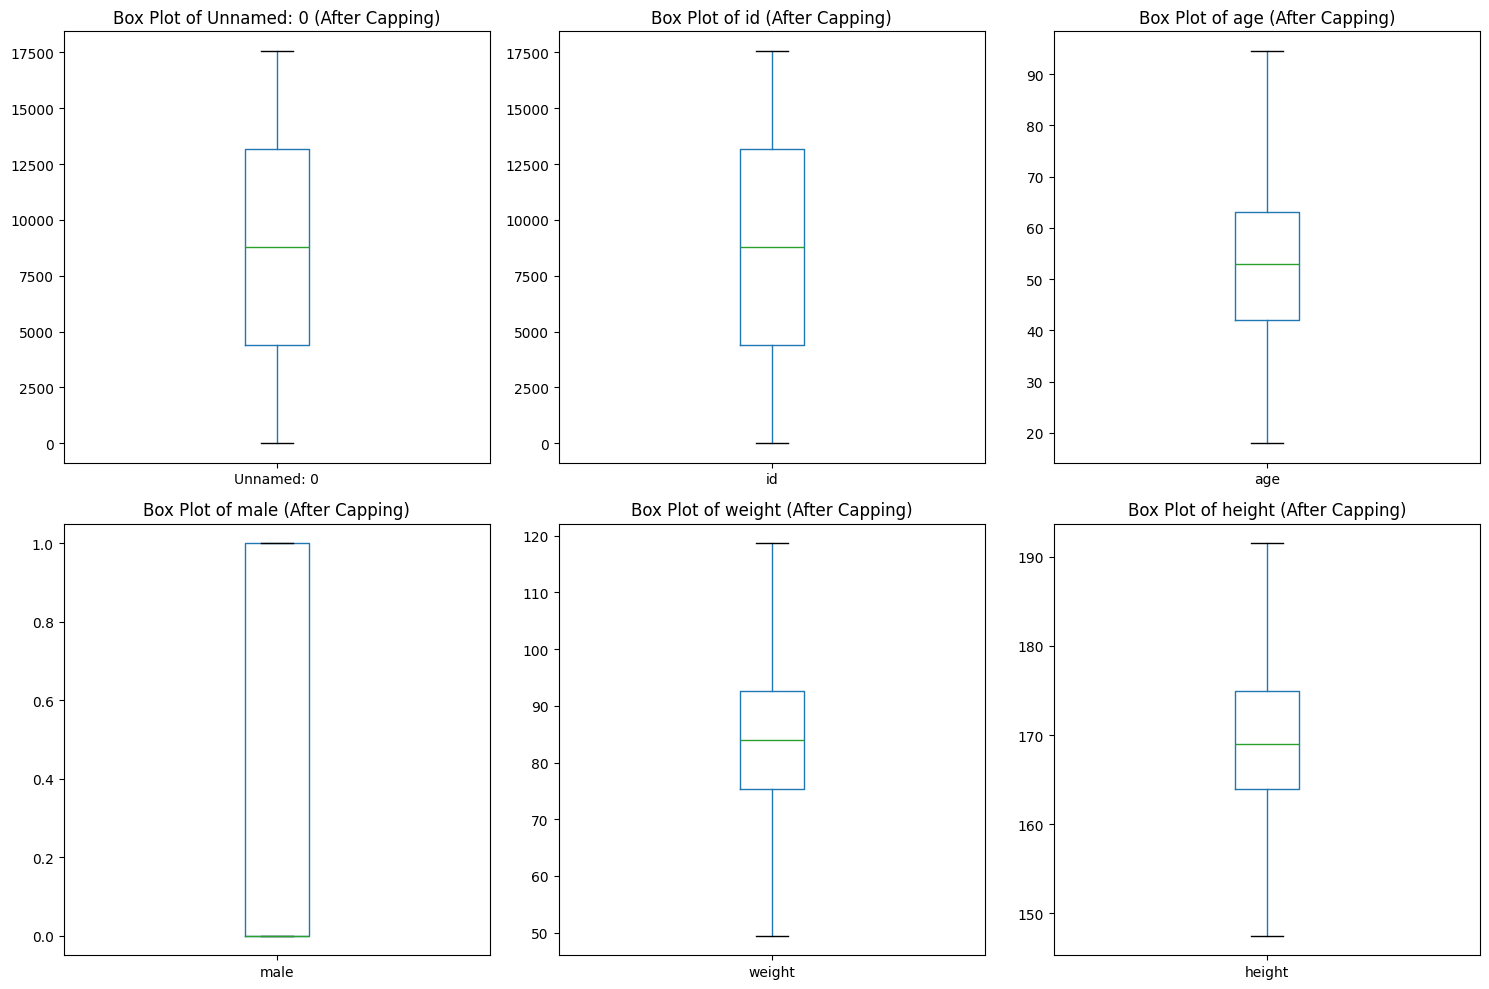

Shape after capping outliers: (17549, 10)


In [13]:


# Plot boxplots AFTER capping
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features[:6], 1):
    plt.subplot(2, 3, i)
    df_capped.boxplot(column=[feature])
    plt.title(f'Box Plot of {feature} (After Capping)')
    plt.grid(False)
plt.tight_layout()
plt.show()

# Final shape
print("Shape after capping outliers:", df_capped.shape)

# Without balancing model apply

In [14]:
# 3. Prepare data
X = df.drop(["id", "status"], axis=1)  # Drop identifier and target
y = df["status"]

In [15]:
from sklearn.model_selection import train_test_split

# Split the data, ensuring stratification (preserving the proportion of classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [16]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "LDA": LinearDiscriminantAnalysis()
}




===== Random Forest =====
Accuracy: 0.9301994301994302
Precision: 0.6794871794871795
Recall: 0.19413919413919414
Confusion Matrix:
 [[3212   25]
 [ 220   53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      3237
           1       0.68      0.19      0.30       273

    accuracy                           0.93      3510
   macro avg       0.81      0.59      0.63      3510
weighted avg       0.92      0.93      0.91      3510



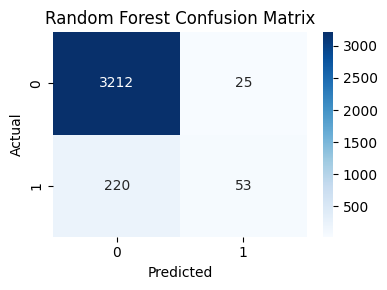


===== Gradient Boosting =====
Accuracy: 0.9299145299145299
Precision: 0.6753246753246753
Recall: 0.19047619047619047
Confusion Matrix:
 [[3212   25]
 [ 221   52]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      3237
           1       0.68      0.19      0.30       273

    accuracy                           0.93      3510
   macro avg       0.81      0.59      0.63      3510
weighted avg       0.92      0.93      0.91      3510



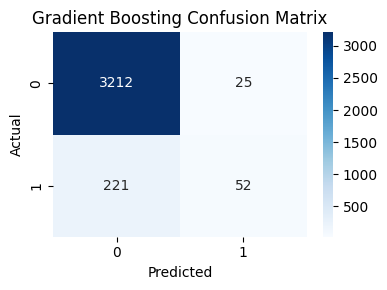


===== Logistic Regression =====
Accuracy: 0.9259259259259259
Precision: 0.6382978723404256
Recall: 0.10989010989010989
Confusion Matrix:
 [[3220   17]
 [ 243   30]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      3237
           1       0.64      0.11      0.19       273

    accuracy                           0.93      3510
   macro avg       0.78      0.55      0.57      3510
weighted avg       0.91      0.93      0.90      3510



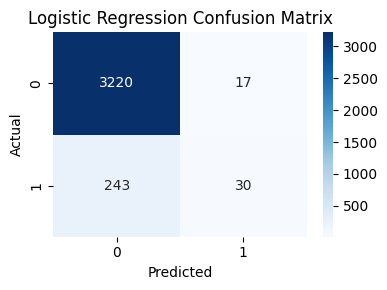


===== Ridge Classifier =====
Accuracy: 0.9222222222222223
Precision: 0.0
Recall: 0.0
Confusion Matrix:
 [[3237    0]
 [ 273    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      3237
           1       0.00      0.00      0.00       273

    accuracy                           0.92      3510
   macro avg       0.46      0.50      0.48      3510
weighted avg       0.85      0.92      0.88      3510



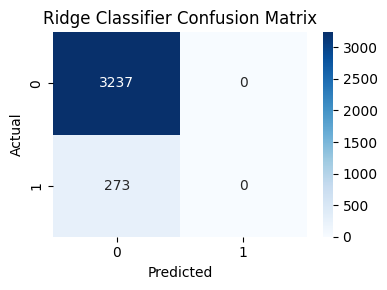


===== Decision Tree =====
Accuracy: 0.8871794871794871
Precision: 0.2826855123674912
Recall: 0.29304029304029305
Confusion Matrix:
 [[3034  203]
 [ 193   80]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      3237
           1       0.28      0.29      0.29       273

    accuracy                           0.89      3510
   macro avg       0.61      0.62      0.61      3510
weighted avg       0.89      0.89      0.89      3510



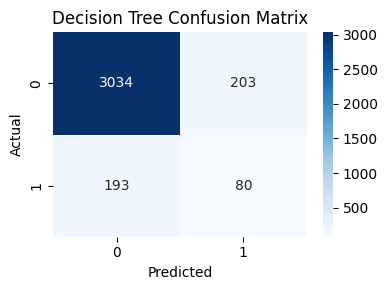


===== Naive Bayes =====
Accuracy: 0.9236467236467236
Precision: 0.5301204819277109
Recall: 0.16117216117216118
Confusion Matrix:
 [[3198   39]
 [ 229   44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      3237
           1       0.53      0.16      0.25       273

    accuracy                           0.92      3510
   macro avg       0.73      0.57      0.60      3510
weighted avg       0.90      0.92      0.90      3510



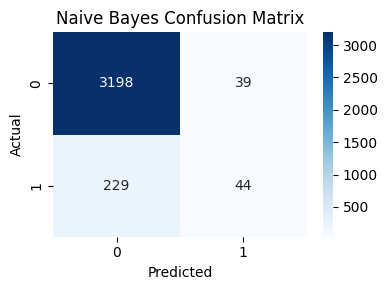


===== KNN =====
Accuracy: 0.917094017094017
Precision: 0.32
Recall: 0.05860805860805861
Confusion Matrix:
 [[3203   34]
 [ 257   16]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      3237
           1       0.32      0.06      0.10       273

    accuracy                           0.92      3510
   macro avg       0.62      0.52      0.53      3510
weighted avg       0.88      0.92      0.89      3510



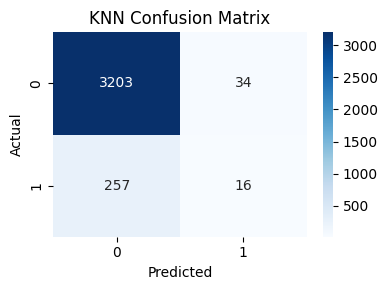


===== LDA =====
Accuracy: 0.927065527065527
Precision: 0.6888888888888889
Recall: 0.11355311355311355
Confusion Matrix:
 [[3223   14]
 [ 242   31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      3237
           1       0.69      0.11      0.19       273

    accuracy                           0.93      3510
   macro avg       0.81      0.55      0.58      3510
weighted avg       0.91      0.93      0.90      3510



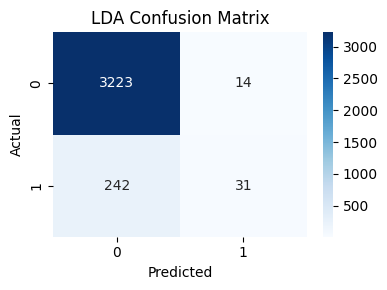

In [17]:
# 6. Train and evaluate
results = []

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)

    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    # Append to results for comparison
    results.append({"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec})

    # Plot confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


In [ ]:

# 7. Show all model performances
results_df = pd.DataFrame(results)
print("\n\n=== Summary of Results ===")
print(results_df.sort_values(by="Accuracy", ascending=False))



=== Summary of Results ===
                 Model  Accuracy  Precision    Recall
0        Random Forest  0.930199   0.679487  0.194139
1    Gradient Boosting  0.929915   0.675325  0.190476
7                  LDA  0.927066   0.688889  0.113553
2  Logistic Regression  0.925926   0.638298  0.109890
5          Naive Bayes  0.923647   0.530120  0.161172
3     Ridge Classifier  0.922222   0.000000  0.000000
6                  KNN  0.917094   0.320000  0.058608
4        Decision Tree  0.887179   0.282686  0.293040


# Balancing Dataset

In [ ]:
print(df_capped.columns)


Index(['Unnamed: 0', 'id', 'age', 'male', 'weight', 'height', 'bmi', 'case.id',
       'futime', 'status'],
      dtype='object')


In [ ]:
print(df.columns)


Index(['Unnamed: 0', 'id', 'age', 'male', 'weight', 'height', 'bmi', 'case.id',
       'futime', 'status'],
      dtype='object')


In [ ]:
# Define X (features) and y (target)
X = df.drop('status', axis=1)  # Features: Drop the target column
y = df['status']  # Target: Assuming 'Outcome' is the column with labels


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data, ensuring stratification (preserving the proportion of classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# SMOTE Apply

In [ ]:
# Split the resampled and scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic samples for the minority class.
from imblearn.over_sampling import SMOTE
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Convert back to DataFrame to visualize the resampled data
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['RiskLevel'])], axis=1)
print(df_resampled['RiskLevel'].value_counts())

Series([], Name: count, dtype: int64)


            Unnamed: 0        id       age      male    weight    height  \
Unnamed: 0    1.000000 -0.009916 -0.288379  0.014677 -0.040849  0.021938   
id           -0.009916  1.000000 -0.004480 -0.000168  0.005636 -0.005426   
age          -0.288379 -0.004480  1.000000 -0.051294 -0.068464 -0.160570   
male          0.014677 -0.000168 -0.051294  1.000000  0.312622  0.632615   
weight       -0.040849  0.005636 -0.068464  0.312622  1.000000  0.439091   
height        0.021938 -0.005426 -0.160570  0.632615  0.439091  1.000000   
bmi          -0.061698  0.013023  0.009335  0.044740  0.868341  0.015650   
case.id       0.005429  0.206010 -0.028174  0.011810  0.000427  0.011667   
futime       -0.215399 -0.011075 -0.087771 -0.020052 -0.001671  0.009665   
status             NaN       NaN       NaN       NaN       NaN       NaN   

                 bmi   case.id    futime  status  
Unnamed: 0 -0.061698  0.005429 -0.215399     NaN  
id          0.013023  0.206010 -0.011075     NaN  
age       

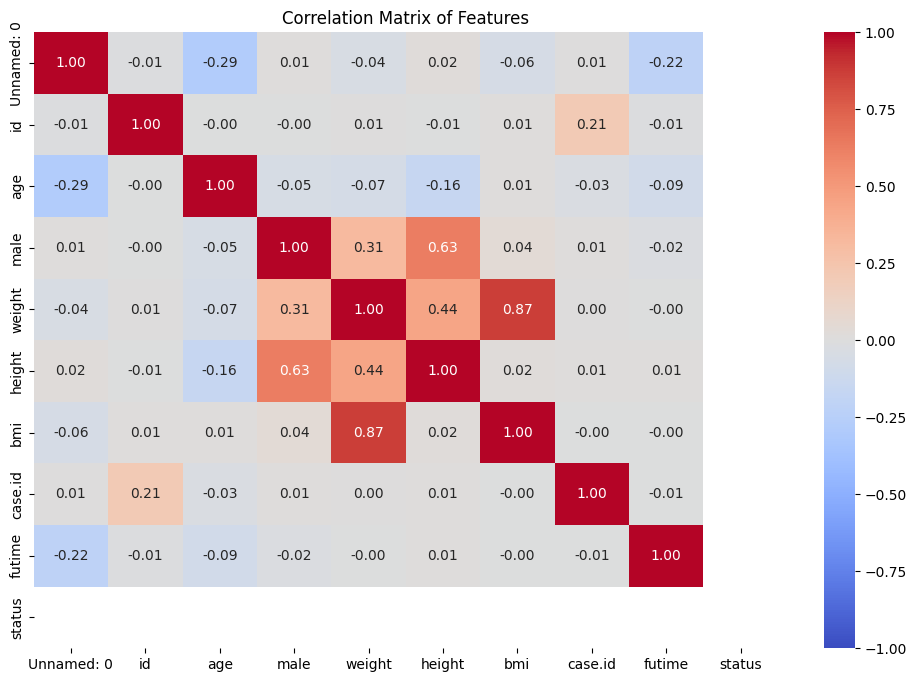

In [ ]:
correlation_matrix = df_capped.corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Features")
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
# Initialize the Decision Tree model
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)

# Train the model with the resampled data (after SMOTE)
dt_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_pred = dt_model.predict(X_test)

# Evaluate the accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Classifier Accuracy: {accuracy:.4f}")


Decision Tree Classifier Accuracy: 0.8251


# From notebook

In [ ]:
# Define X (features) and y (target)
X = df.drop(["id", "status"], axis=1)  # Dropping 'id' and 'status' (target) columns
y = df["status"]  # 'status' is the target variable


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [ ]:
from sklearn.impute import SimpleImputer
pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler(),
    RandomForestClassifier(n_estimators=250)
)

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=250))])

In [ ]:
predictions = pipeline.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Random Forest Classifier Accuracy : {:.2f}%".format(accuracy * 100))

Random Forest Classifier Accuracy : 93.22%


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

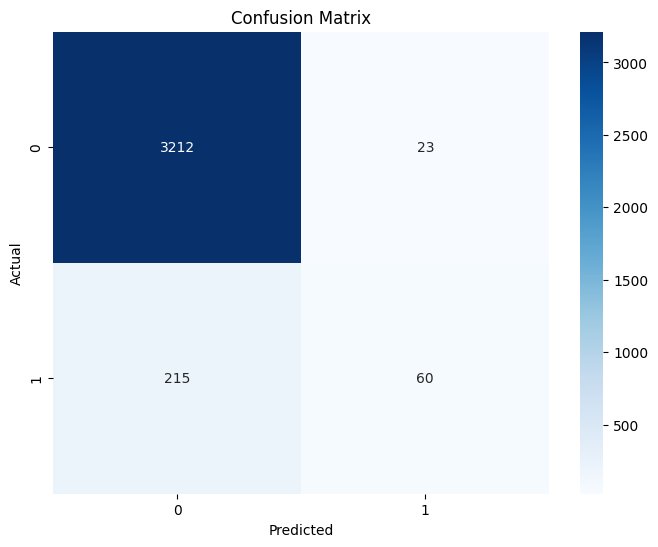

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


===== Random Forest =====
Accuracy: 0.9322
Precision: 0.7229
Recall: 0.2182
Confusion Matrix:
 [[3212   23]
 [ 215   60]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      3235
           1       0.72      0.22      0.34       275

    accuracy                           0.93      3510
   macro avg       0.83      0.61      0.65      3510
weighted avg       0.92      0.93      0.91      3510



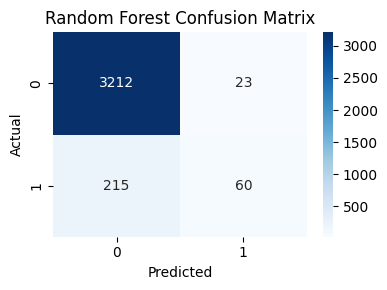


===== Gradient Boosting =====
Accuracy: 0.9313
Precision: 0.6889
Recall: 0.2255
Confusion Matrix:
 [[3207   28]
 [ 213   62]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      3235
           1       0.69      0.23      0.34       275

    accuracy                           0.93      3510
   macro avg       0.81      0.61      0.65      3510
weighted avg       0.92      0.93      0.91      3510



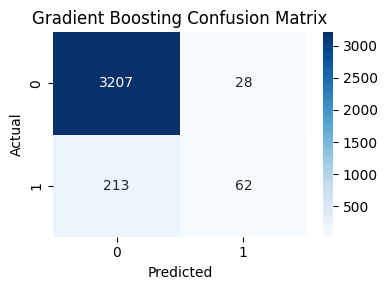


===== Logistic Regression =====
Accuracy: 0.9265
Precision: 0.6667
Recall: 0.1236
Confusion Matrix:
 [[3218   17]
 [ 241   34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      3235
           1       0.67      0.12      0.21       275

    accuracy                           0.93      3510
   macro avg       0.80      0.56      0.59      3510
weighted avg       0.91      0.93      0.90      3510



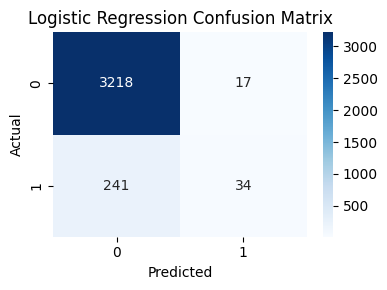


===== Ridge Classifier =====
Accuracy: 0.9217
Precision: 0.0000
Recall: 0.0000
Confusion Matrix:
 [[3235    0]
 [ 275    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      3235
           1       0.00      0.00      0.00       275

    accuracy                           0.92      3510
   macro avg       0.46      0.50      0.48      3510
weighted avg       0.85      0.92      0.88      3510



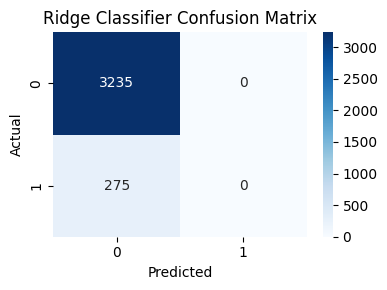


===== Decision Tree =====
Accuracy: 0.8875
Precision: 0.2902
Recall: 0.3018
Confusion Matrix:
 [[3032  203]
 [ 192   83]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      3235
           1       0.29      0.30      0.30       275

    accuracy                           0.89      3510
   macro avg       0.62      0.62      0.62      3510
weighted avg       0.89      0.89      0.89      3510



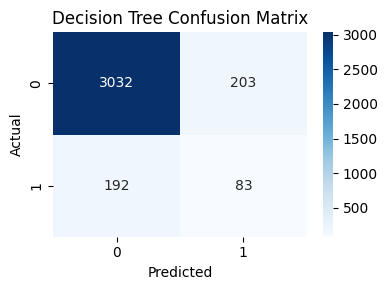


===== Naive Bayes =====
Accuracy: 0.9228
Precision: 0.5270
Recall: 0.1418
Confusion Matrix:
 [[3200   35]
 [ 236   39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      3235
           1       0.53      0.14      0.22       275

    accuracy                           0.92      3510
   macro avg       0.73      0.57      0.59      3510
weighted avg       0.90      0.92      0.90      3510



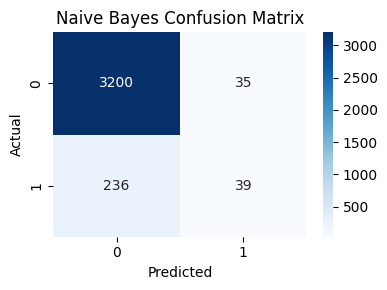


===== KNN =====
Accuracy: 0.9185
Precision: 0.3962
Recall: 0.0764
Confusion Matrix:
 [[3203   32]
 [ 254   21]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      3235
           1       0.40      0.08      0.13       275

    accuracy                           0.92      3510
   macro avg       0.66      0.53      0.54      3510
weighted avg       0.88      0.92      0.89      3510



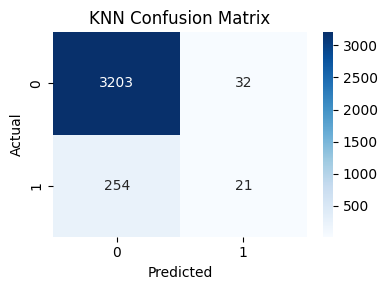


===== LDA =====
Accuracy: 0.9254
Precision: 0.6327
Recall: 0.1127
Confusion Matrix:
 [[3217   18]
 [ 244   31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      3235
           1       0.63      0.11      0.19       275

    accuracy                           0.93      3510
   macro avg       0.78      0.55      0.58      3510
weighted avg       0.91      0.93      0.90      3510



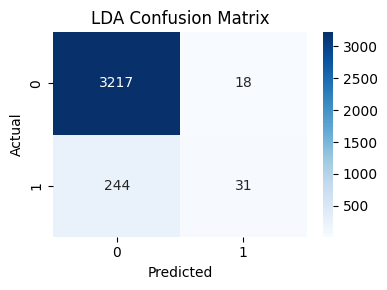



=== Summary of Model Performance ===
                 Model  Accuracy  Precision    Recall
0        Random Forest  0.932194   0.722892  0.218182
1    Gradient Boosting  0.931339   0.688889  0.225455
2  Logistic Regression  0.926496   0.666667  0.123636
7                  LDA  0.925356   0.632653  0.112727
5          Naive Bayes  0.922792   0.527027  0.141818
3     Ridge Classifier  0.921652   0.000000  0.000000
6                  KNN  0.918519   0.396226  0.076364
4        Decision Tree  0.887464   0.290210  0.301818


In [ ]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "LDA": LinearDiscriminantAnalysis()
}

# 5. Train, Predict, and Evaluate
results = []

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    results.append({"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec})

    # Confusion matrix plot
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# 6. Compare all models
results_df = pd.DataFrame(results)
print("\n\n=== Summary of Model Performance ===")
print(results_df.sort_values(by="Accuracy", ascending=False))

# other model applying

In [ ]:
# Define X (features) and y (target)
X = df.drop('status', axis=1)  # Features: Drop the target column
y = df['status']  # Target: Assuming 'Outcome' is the column with labels


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data, ensuring stratification (preserving the proportion of classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Define a lighter model set to start with
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "LDA": LinearDiscriminantAnalysis()
}

# Evaluate each model
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))



===== Random Forest =====
Accuracy: 0.9615384615384616
Precision: 0.7078313253012049
Recall: 0.8608058608058609
Confusion Matrix:
 [[3140   97]
 [  38  235]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3237
           1       0.71      0.86      0.78       273

    accuracy                           0.96      3510
   macro avg       0.85      0.92      0.88      3510
weighted avg       0.97      0.96      0.96      3510


===== Gradient Boosting =====
Accuracy: 0.8111111111111111
Precision: 0.23790322580645162
Recall: 0.6483516483516484
Confusion Matrix:
 [[2670  567]
 [  96  177]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89      3237
           1       0.24      0.65      0.35       273

    accuracy                           0.81      3510
   macro avg       0.60      0.74      0.62      3510
weighted avg       0.91      0


===== Random Forest =====
Accuracy: 0.9615
Precision: 0.7078313253012049
Recall: 0.8608058608058609
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3237
           1       0.71      0.86      0.78       273

    accuracy                           0.96      3510
   macro avg       0.85      0.92      0.88      3510
weighted avg       0.97      0.96      0.96      3510



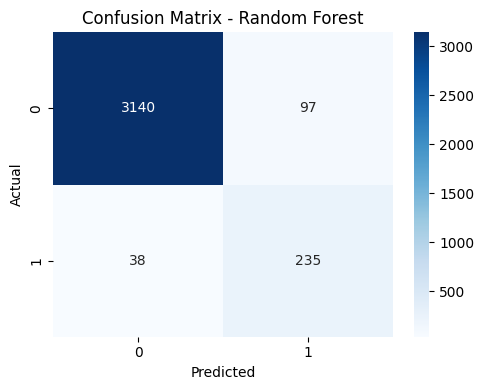


===== Gradient Boosting =====
Accuracy: 0.8111
Precision: 0.23790322580645162
Recall: 0.6483516483516484
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89      3237
           1       0.24      0.65      0.35       273

    accuracy                           0.81      3510
   macro avg       0.60      0.74      0.62      3510
weighted avg       0.91      0.81      0.85      3510



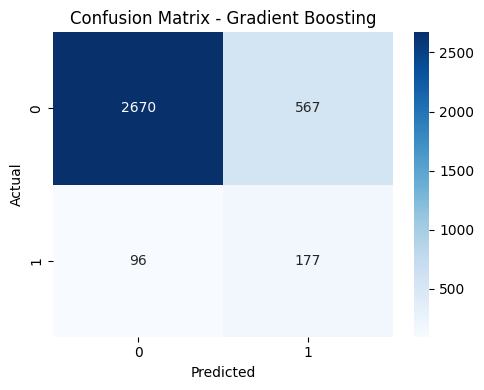


===== Logistic Regression =====
Accuracy: 0.7464
Precision: 0.197252208047105
Recall: 0.7362637362637363
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.75      0.84      3237
           1       0.20      0.74      0.31       273

    accuracy                           0.75      3510
   macro avg       0.58      0.74      0.58      3510
weighted avg       0.91      0.75      0.80      3510



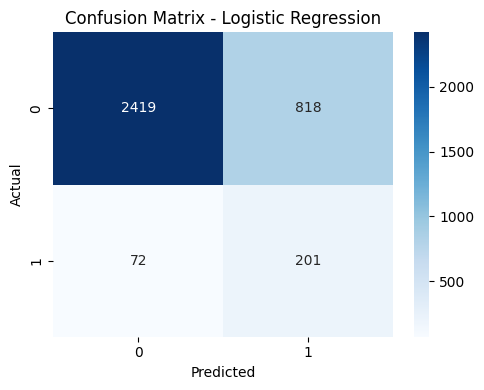


===== Ridge Classifier =====
Accuracy: 0.7365
Precision: 0.19303201506591336
Recall: 0.7509157509157509
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84      3237
           1       0.19      0.75      0.31       273

    accuracy                           0.74      3510
   macro avg       0.58      0.74      0.57      3510
weighted avg       0.91      0.74      0.80      3510



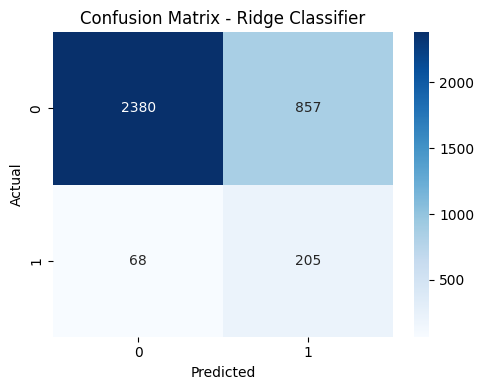


===== Decision Tree =====
Accuracy: 0.9613
Precision: 0.7032640949554896
Recall: 0.8681318681318682
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3237
           1       0.70      0.87      0.78       273

    accuracy                           0.96      3510
   macro avg       0.85      0.92      0.88      3510
weighted avg       0.97      0.96      0.96      3510



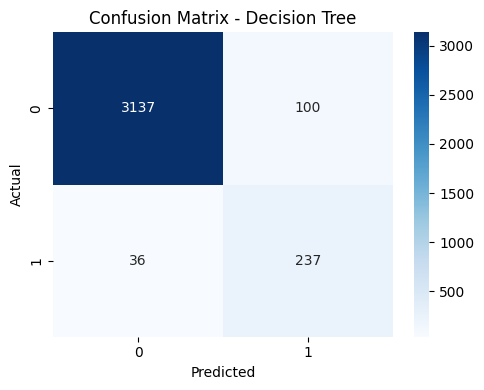


===== Naive Bayes =====
Accuracy: 0.712
Precision: 0.17402826855123674
Recall: 0.7216117216117216
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.71      0.82      3237
           1       0.17      0.72      0.28       273

    accuracy                           0.71      3510
   macro avg       0.57      0.72      0.55      3510
weighted avg       0.91      0.71      0.78      3510



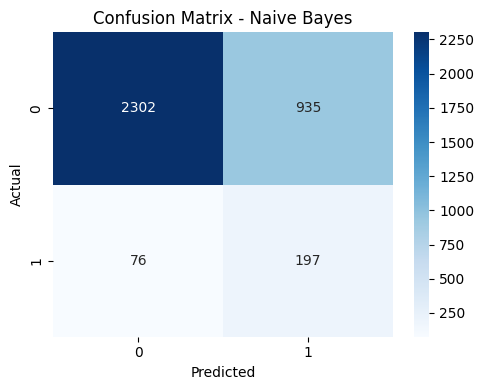


===== KNN =====
Accuracy: 0.8197
Precision: 0.2788697788697789
Recall: 0.8315018315018315
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      3237
           1       0.28      0.83      0.42       273

    accuracy                           0.82      3510
   macro avg       0.63      0.83      0.66      3510
weighted avg       0.93      0.82      0.86      3510



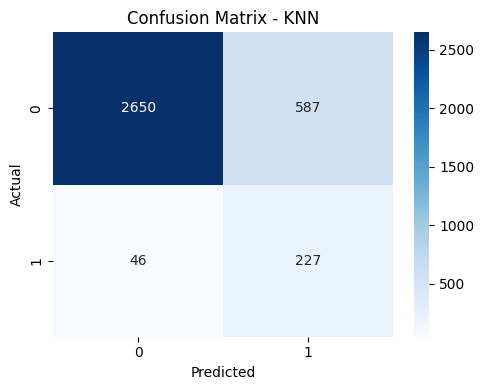


===== LDA =====
Accuracy: 0.7365
Precision: 0.19303201506591336
Recall: 0.7509157509157509
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84      3237
           1       0.19      0.75      0.31       273

    accuracy                           0.74      3510
   macro avg       0.58      0.74      0.57      3510
weighted avg       0.91      0.74      0.80      3510



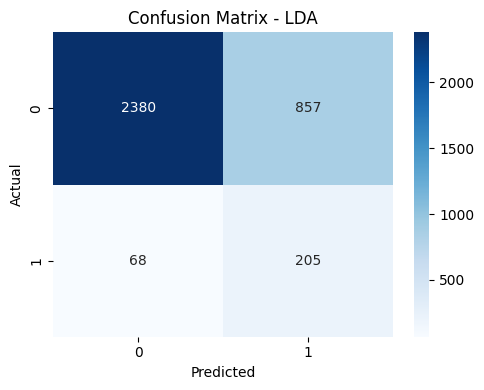


🏆 Best Model based on Accuracy: Random Forest (0.9615)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Classifiers to evaluate
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "LDA": LinearDiscriminantAnalysis()
}

# Store accuracy results
accuracy_results = {}

# Evaluate and visualize
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results[name] = accuracy

    print("Accuracy:", round(accuracy, 4))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, zero_division=0))
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Identify the best model
best_model = max(accuracy_results, key=accuracy_results.get)
print(f"\n🏆 Best Model based on Accuracy: {best_model} ({accuracy_results[best_model]:.4f})")


# Increase the accuracy

In [ ]:
# STEP 2: Feature Engineering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# STEP 2: Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(X.columns)

# STEP 3: Feature Selection
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_poly, y)
selected_features = selector.get_support()

# Print selected feature names
print("Selected features:", np.array(feature_names)[selected_features])


Selected features: ['Unnamed: 0' 'age' 'Unnamed: 0 height' 'Unnamed: 0 futime' 'id age'
 'age^2' 'age weight' 'age height' 'age bmi' 'age case.id']


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9629629629629629
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3237
           1       0.72      0.87      0.78       273

    accuracy                           0.96      3510
   macro avg       0.85      0.92      0.88      3510
weighted avg       0.97      0.96      0.96      3510



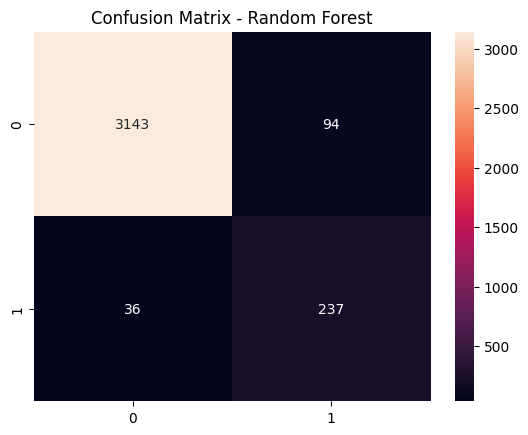

In [ ]:
# STEP 5: Model Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_resampled, y_train_resampled)
print("Best Parameters:", grid.best_params_)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()

Voting Classifier Accuracy: 0.9606837606837607


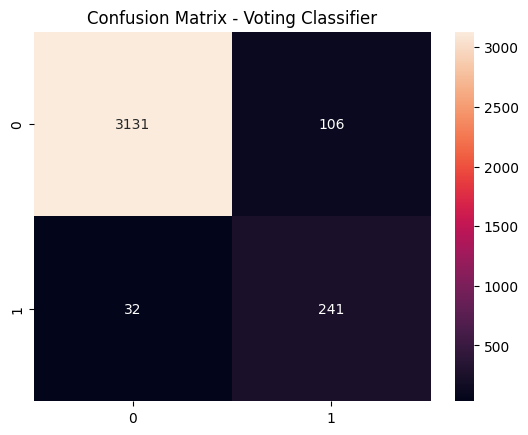

In [ ]:
# STEP 6: Ensemble - Voting Classifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

voting = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('nb', GaussianNB()),
    ('dt', DecisionTreeClassifier(random_state=42))
], voting='hard')

voting.fit(X_train_resampled, y_train_resampled)
y_pred_vote = voting.predict(X_test)

print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_vote))
sns.heatmap(confusion_matrix(y_test, y_pred_vote), annot=True, fmt='d')
plt.title("Confusion Matrix - Voting Classifier")
plt.show()

In [ ]:
# STEP 7: Anomaly Detection
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_selected)
outliers = iso_forest.predict(X_selected)
print("Outliers detected:", list(outliers).count(-1))

Outliers detected: 3576


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/liver disease dataset/nafld1.csv")  # replace with your actual CSV filename

# Prepare data
X = df.drop(["id", "status"], axis=1)
y = df["status"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Save model to a file
joblib.dump(rf_model, "model.pkl")

print("✅ Model trained and saved as model.pkl")


✅ Model trained and saved as model.pkl
